<h3><b>A rudimentary implementation of logistic regression</b><h3>

In [32]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# Detect GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print(f"Using device: {device}");

# Load the dataset
dataFrame = pd.read_csv("perceptron_data.txt", sep='\t');
X_train = dataFrame[['x1', 'x2']].values;
Y_train = dataFrame['label'].values;

# Convert to torch tensors
X_train = torch.from_numpy(X_train).to(torch.float32);
Y_train = torch.from_numpy(Y_train).to(torch.float32);

Using device: cuda


In [33]:
dataFrame

,x1,x2,label
0,3.28,3.20,0
1,1.91,3.00,0
2,3.26,1.81,0
3,7.78,5.83,1
4,6.81,5.51,1
5,4.86,2.63,0
6,3.81,3.21,0
7,6.20,6.21,1
8,7.74,6.16,1
9,4.87,1.56,0


<h3><b>Visualizing the data points</h3></b>

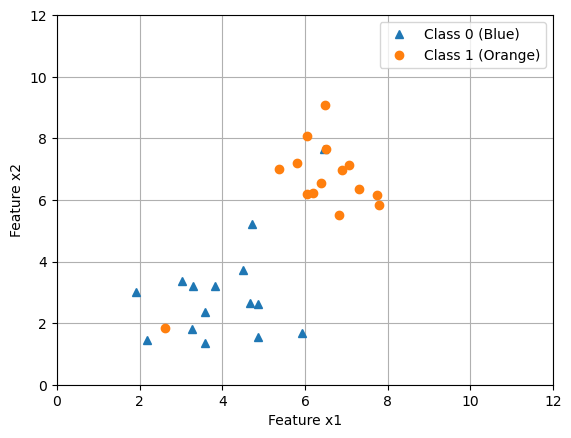

In [34]:
# Plot the data points
plt.plot(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1], '^', label="Class 0 (Blue)");
plt.plot(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], 'o', label="Class 1 (Orange)");
plt.ylim(0, 12);
plt.xlim(0, 12);
plt.xlabel('Feature x1');
plt.ylabel('Feature x2');
plt.legend();
plt.grid();
plt.show();

<h3><b>Creating the modified Perceptron</h3></b>

In [35]:
class Perceptron:
    def __init__(self, numFeatures: int, learningRate: float, device: torch.device = torch.device("cpu")):
        self.__device = device;
        self.__weights = torch.zeros(numFeatures, requires_grad=True, device=self.__device);
        self.__bias = torch.tensor(0.0, requires_grad=True, device=self.__device);
        self.__learningRate = learningRate;
    
    def __activation(self, z: torch.Tensor):
        """
            Sigmoid activation function
        """
        return 1 / (1 + torch.exp(-z));

    def __lossFunction(self, a: torch.Tensor, y: torch.Tensor):
        """
            Binary Cross-Entropy: 1 data point
        """
        return -y * torch.log(a) - (1 - y) * torch.log(1 - a);

    def __forward(self, x: torch.Tensor):
        """
            Computes the sigmoid for the sum of the weights and bias
        """
        return self.__activation(torch.dot(self.__weights, x) + self.__bias);
    
    def train(self, X_data: torch.Tensor, Y_data: torch.Tensor, epochs: int):
        """
            Trains the perceptron with gradient descent
        """
        X_data, Y_data = X_data.to(self.__device), Y_data.to(self.__device);

        for epoch in range(epochs):
            # Compute the loss over the entire epoch
            overall_loss_L = 0;

            for x, y in zip(X_data, Y_data):
                output = self.__forward(x);
                overall_loss_L += self.__lossFunction(output, y);

            overall_loss_L /= len(X_data); # Normalize loss

            # Update parameters once per epoch
            overall_loss_L.backward();
            with torch.no_grad():
                self.__weights -= self.__learningRate * self.__weights.grad;
                self.__bias -= self.__learningRate * self.__bias.grad;
            
            # Reset gradients
            self.__weights.grad.zero_();
            self.__bias.grad.zero_();

            print(f"Epoch {epoch + 1}, Loss: {overall_loss_L.item()}");
    
    def computeAccuracy(self, X_data: torch.Tensor, Y_label: torch.Tensor):
        """
            Computes accuracy of the model on a given dataset
        """
        X_data, Y_label = X_data.to(self.__device), Y_label.to(self.__device);
        correct = 0.0;

        with torch.no_grad():
            for x, y in zip(X_data, Y_label):
                prediction = self.__forward(x);
                predicted_label = 1 if prediction >= 0.5 else 0;
                correct += int(predicted_label == y.item());

        return correct / len(Y_label);

    def getWeights(self) -> torch.Tensor:
        return self.__weights;

    def getBias(self) -> torch.Tensor:
        return self.__bias;


In [ ]:
perceptron = Perceptron(numFeatures=2, learningRate=0.01, device=device);
perceptron.train(X_train, Y_train, epochs=10000);

<h3><b>Evaluating the accuracy</b></h3>

In [37]:
accuracy = perceptron.computeAccuracy(X_train, Y_train);
print(f'Accuracy: {accuracy*100}%');

Accuracy: 90.0%


<h3><b>Visualizing the decision boundary</b></h3>

In [38]:
def plot_decision_boundary(model):
    w1 = model.getWeights()[0].detach().cpu().numpy();
    w2 = model.getWeights()[1].detach().cpu().numpy();
    b = model.getBias().detach().cpu().numpy();
    
    assert w2 != 0
    
    x1_min = -100
    x2_min = (-b -(w1 * x1_min)) / w2
    
    x1_max = 100
    x2_max =( -b -(w1 * x1_max)) / w2
    
    return x1_min, x2_min, x1_max, x2_max

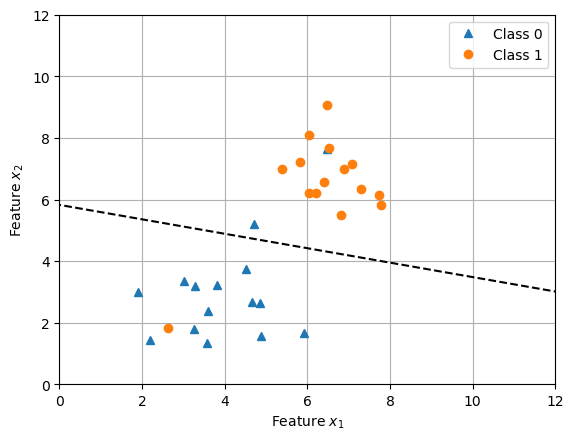

In [39]:
# Plotting the decision boundary
plt.plot(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1], '^', label="Class 0");
plt.plot(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], 'o', label="Class 1");
plt.ylim(0,12);
plt.xlim(0,12);
plt.xlabel("Feature $x_1$");
plt.ylabel("Feature $x_2$");
plt.legend();
plt.grid();

x1_min, x2_min, x1_max, x2_max = plot_decision_boundary(perceptron);
plt.plot([x1_min, x1_max], [x2_min, x2_max], 'k--');

plt.show();